# BASELINE IMAGE FEATURES CLASSIFICATION VIA CLIP

In this experiment, we're going to use CLIP (```openai/clip-vit-base-patch32```) as a frozen features extractor on the **CIFAR-100** image classification task. We will extract 512-dimensional image embeddings and we'll train a linear Support Vector Machine (**SVM**) as a classifier.

This experiment will serve as a baseline for common approaches to benchmark **zero-shot** or **few-shot** CLIP classification. Why is that?
Even though we're using an **SVM** (which does use training data), we are not training the CLIP model itself — we're just using its pre-trained knowledge to extract image features. So using CLIP's embeddings and training a simple model like **SVM**, we are benchmarking how goog CLIP's built-in features are and if the **SVM** does weel with little training data. It would mean CLIP already capture very meaning information - which is exactly what we'd expect from a **zero-shot/few-shot** capable model.

##Dependecies & Setup

Intalling dependencies and necessary libraries.

In [ ]:
!pip install -q transformers datasets torchvision matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

##Step1: Load CLIP model (```openai/clip-vit-base-patch32```) and CIFAR-100 dataset

We're about to load the CLIP model, its image processor (preprocessing) and **CIFAR-100** from Hugging Face.

*Some notes: CLIP expects images resized to 224x224, but CIFAR-10 images are 32x32. Resizing is mandatory.*

In [ ]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)

# Loads a processor that handles preprocessing for both image and text inputs,
# making them ready for the CLIP model
clip_processor = CLIPProcessor.from_pretrained(model_name)

# Put model on device
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device).eval()

# Define a transform to convert CIFAR-100 images to PIL images. Indeed CLIP
# processor expects images as PIL Images, not as raw tensors.
to_pil = transforms.ToPILImage() # PIL := Python Imaging Library

# Load CIFAR-100 training dataset, which consists of 60,000 color images
# (32x32 pixels) in 100 classes (e.g., airplane, cat, truck).
train_dataset = CIFAR100(root="./data", train=True, download=True)
test_dataset = CIFAR100(root="./data", train=False, download=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 169M/169M [00:03<00:00, 42.3MB/s]


##Step2: Extract Image Embeddings from CLIP

We're going to take each **CIFAR-100** image, preprocess it using  ```CLIPProcessor ```, pass it through the  ```CLIModel ``` to get image embeddings (features vectors). A the end we have to store these embeddings along with their labels for training our classifier.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

In [ ]:
# Custom Dataset to wrap CIFAR-100 and apply CLIP preprocessing
class CLIPImageDataset(Dataset):
    def __init__(self, cifar_dataset):
        self.dataset = cifar_dataset

    def __len__(self):
        return len(self.dataset) # It simply returns the number of samples in
                                 # the original CIFAR-100 dataset.


    def __getitem__(self, idx):
        image, label = self.dataset[idx] # Retrieves the idx-th (img, lbl) pair
                                         # from the original CIFAR-100 dataset
        # Process with CLIP processor
        processed = clip_processor(images=image, return_tensors="pt")

        # We return a tuple: (processed_image_tensor, label) — suitable for
        # training or inference
        # with squeeze we remove the extra batch dimension
        return processed["pixel_values"].squeeze(0), label


In [ ]:
# Let's transform CIFAR-100 datasets into datasets compatible with the CLIP model
train_clip_dataset = CLIPImageDataset(train_dataset)
test_clip_dataset = CLIPImageDataset(test_dataset)

In [ ]:
# dataloader allow us to iterate on batch data (generally 64 per time)
# shuffle = false means data are read in order
train_loader = DataLoader(train_clip_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_clip_dataset, batch_size=64, shuffle=False)

In [ ]:
#Function for extracting embeddings
def extract_embeddings(dataloader):
    all_embeddings = []
    all_labels = []

    with torch.no_grad(): # I'm not training but just feature extraction
                          # (inference)
        for images, labels in tqdm(dataloader):
            images = images.to(device) # move img to GPU is it available

            # the next line returns a feature vector (embedding) for each image
            # — typically 512-dimensional for ViT-B/32
            embeddings = clip_model.get_image_features(images)
            embeddings = embeddings.cpu().numpy() # convert embeddings into
                                                  # NumPy arrar in order to use
                                                  # them on scikit-learn later
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())

    # np.vstack(...) stacks all embeddings vertically into a big matrix:
    # shape will be [N, D] where N = number of images, D = embedding size (512)
    # and convert the label list to NumPy array
    return np.vstack(all_embeddings), np.array(all_labels)

In [ ]:
# Extract embeddings
train_features, train_labels = extract_embeddings(train_loader)
test_features, test_labels = extract_embeddings(test_loader)

print("\nTrain features shape:", train_features.shape)
print("\nTest features shape:", test_features.shape)

100%|██████████| 157/157 [00:52<00:00,  2.98it/s]


Train features shape: (50000, 512)

Test features shape: (10000, 512)


##Step3: Train a Classifier (SVM)

We're about to use  ```train_features``` and  ```trains_labels``` (CLIP image embeddings and **CIFAR-100** labels) from the previous step in order to train a classifier, and evaluate it.
We'll use Support Vector Machine (**SVM**) with a linear kernel from  ```scikit-learn``` and a standardization of features using  ```StandardScaler``` ('cause SVMs work better with scaled data).

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Standardize features
# Standardization aims to achieve MEAN = 0 and STANDAR DEVIATION = 1 for each
# 512-dimension feature
scaler = StandardScaler() # Standardization ensures fair treatment of each
                          # dimension in the feature space

X_train_scaled = scaler.fit_transform(train_features)
# X_train_scaled is now a standardized version of the CLIP embeddings for the
# training set


X_test_scaled = scaler.transform(test_features) # no fit in order to avoid data
                                                # leakage

In [ ]:
# Train an SVM classifier
# C is a paramter for regulation strength
# kernel = 'linear' uses such linear decision boundary (since embeddings are
# already powerful)
# random_state = 42 for the reproducibility
svm_clf = SVC(kernel = 'linear', C = 1.0, random_state = 42)
svm_clf.fit(X_train_scaled, train_labels)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict on test set
y_pred = svm_clf.predict(X_test_scaled) # Predicts the labels for the test set
                                        # using the trained SVM

# Evaluate
accuracy = accuracy_score(test_labels, y_pred)
print(f"Baseline CLIP image classification: {accuracy * 100:.2f}%")

Baseline CLIP image classification: 78.01%


##Step4: Analyze Result - Confusion Matrix & Graphs

We are about to visualize and interpret the classifier performance using:
  - **Confusion Matrix**: to see which classes are often confused;
  - **Classification Report**: to get precision, recall, F1 score;

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# CIFAR-100 class names
class_names = train_dataset.classes

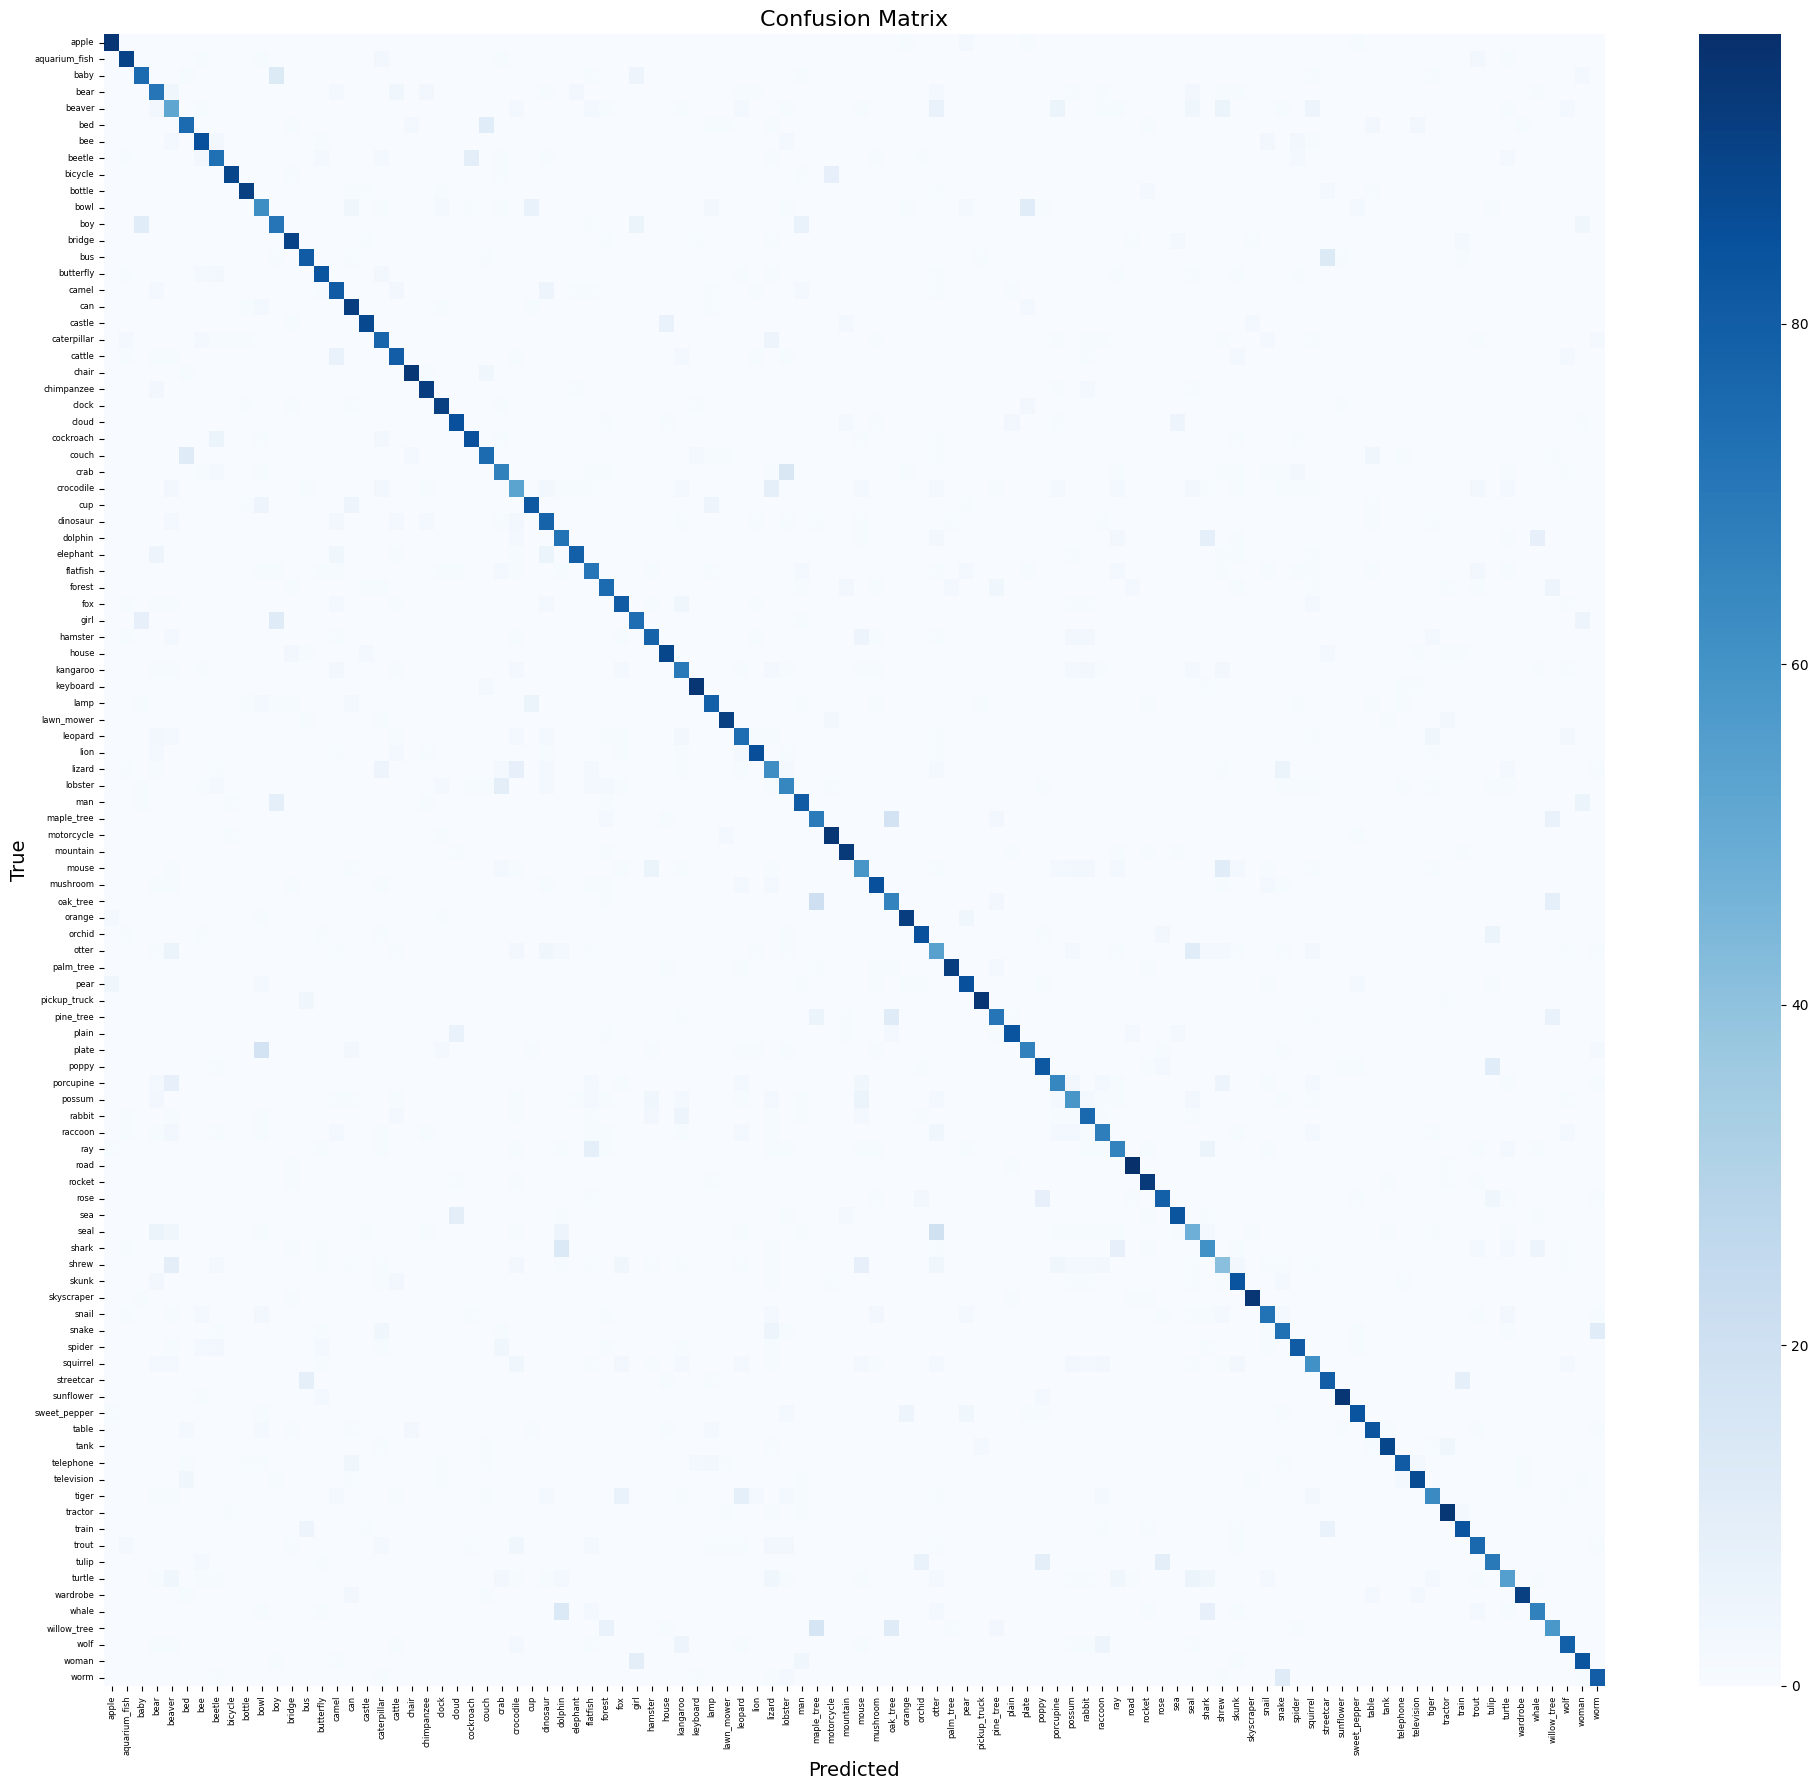

In [ ]:
cm = confusion_matrix(test_labels, y_pred)

# large figure enough to accomodate 100x100 matrix
plt.figure(figsize=(20, 18))

# Plot heatmap without annotations to avoid clutter
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()

plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(test_labels, y_pred, target_names=class_names))

Classification Report:

               precision    recall  f1-score   support

        apple       0.92      0.95      0.94       100
aquarium_fish       0.86      0.90      0.88       100
         baby       0.77      0.75      0.76       100
         bear       0.62      0.71      0.66       100
       beaver       0.46      0.52      0.49       100
          bed       0.77      0.75      0.76       100
          bee       0.80      0.85      0.83       100
       beetle       0.72      0.73      0.73       100
      bicycle       0.96      0.89      0.92       100
       bottle       0.94      0.91      0.92       100
         bowl       0.58      0.62      0.60       100
          boy       0.65      0.71      0.68       100
       bridge       0.85      0.90      0.87       100
          bus       0.79      0.81      0.80       100
    butterfly       0.83      0.84      0.84       100
        camel       0.72      0.81      0.76       100
          can       0.76      0.92      

## Final Insights

**CIFAR-100** contains 100 fine-grained classes with greater visual similarity (e.g. different species or subtypes). The accuracy drop from 93.24% with **CIFAR-10** (see the experiment [here](https://colab.research.google.com/drive/1SehdC_hvCKnXFI4UtJyRhdws6h5POdSA?usp=drive_link)) to 78.01% and that reflects:

*   increased intra-class variability and inter-class similarity in **CIFAR-100**;
*   the limited resolution and complexity of CIFAR images (32x32), which can challenge even strong pretrained features.

The classification report high-performing classes (**F1 ≥ 0.90**) for classes like *pickup_truck*, *wardrobe*, *keyboard*, *chair*, etc; low-performing classes (**F1 ≤ 0.60**) for *beaver*, *shrew*, *seal*, *crocodile*, etc.
Human classes like *boy*, *girl*, *man*, *woman* perform moderately well (~0.75–0.82), maybe suggesting that CLIP captures some semantic consistency but struggles with nuanced identity-based features in low-res images.

As final consideration we observe that many animal classes underperform compared to objects or veichles. This indicates that CLIP (trained on large internet corpora) may prioritize iconic or culturally distinctive objects over fine-grained natural categories, especially when evaluated at low resolution (32x32).



-----------------------------------------